In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import agent as ag
import df_helpers as dfh
import model as ml

from matplotlib import style

from google_window import WindowGenerator
from model import get_lstm_model
# style.use('dark_background')

import importlib
importlib.reload(ag)
importlib.reload(ml)
importlib.reload(dfh)

<module 'df_helpers' from 'c:\\Users\\mathi\\Prosjekter\\Vår 2022\\IT3030\\IT3030-Projects\\Project 3\\df_helpers.py'>

In [170]:
# Open no1_train.csv and no1_validation.csv
original_df_train = pd.read_csv('no1_train.csv')
original_df_val = pd.read_csv('no1_validation.csv')
testing = False
try:
    original_df_test = pd.read_csv('no1_test.csv')
    testing = True
except:
    pass

# Make copies
df_train = original_df_train.copy()
df_val = original_df_val.copy()
if testing:
    df_test = original_df_test.copy()

In [171]:
df_train.head()

,start_time,hydro,micro,thermal,wind,river,total,y,sys_reg,flow
0,2019-01-09 14:10:00,1591.839,141.928,11.5,74.428,0.0,1819.695,341.330021,10.0,-4417.4
1,2019-01-09 14:15:00,1591.839,141.928,11.5,74.428,0.0,1819.695,330.114330,10.0,-4417.4
2,2019-01-09 14:20:00,1591.839,141.928,11.5,74.428,0.0,1819.695,323.877221,10.0,-4417.4
3,2019-01-09 14:25:00,1591.839,141.928,11.5,74.428,0.0,1819.695,296.438463,10.0,-4417.4
4,2019-01-09 14:30:00,1591.839,141.928,11.5,74.428,0.0,1819.695,269.097132,10.0,-4417.4


In [172]:
df_val.head()

,start_time,hydro,micro,thermal,wind,river,total,y,sys_reg,flow
0,2021-03-01 03:30:00,1942.49,191.881,20.1,106.431,0.0,2266.102,52.119595,0.0,-2252.9
1,2021-03-01 03:35:00,1942.49,191.881,20.1,106.431,0.0,2266.102,90.374541,0.0,-2252.9
2,2021-03-01 03:40:00,1942.49,191.881,20.1,106.431,0.0,2266.102,88.435063,0.0,-2252.9
3,2021-03-01 03:45:00,1942.49,191.881,20.1,106.431,0.0,2266.102,53.375518,0.0,-2252.9
4,2021-03-01 03:50:00,1942.49,191.881,20.1,106.431,0.0,2266.102,65.496683,0.0,-2252.9


In [173]:
# Convert timestamps in "start_time" to seconds
df_train['start_time_seconds'] = pd.to_datetime(df_train['start_time'])
df_train['start_time_seconds'] = df_train['start_time_seconds'].apply(lambda x: x.timestamp())

# Do the same to df_val
df_val['start_time_seconds'] = pd.to_datetime(df_val['start_time'])
df_val['start_time_seconds'] = df_val['start_time_seconds'].apply(lambda x: x.timestamp())

# Do the same to df_test
if testing:
    df_test['start_time_seconds'] = pd.to_datetime(df_test['start_time'])
    df_test['start_time_seconds'] = df_test['start_time_seconds'].apply(lambda x: x.timestamp())

## Exploratory Data Analysis

First let's look at the data and see if we notice any outliers that might not correlate well with the overall trend of the data

In [174]:
df_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
hydro,225088.0,1.888334e+03,4.010003e+02,6.834380e+02,1.625029e+03,1.933916e+03,2.175595e+03,2.995524e+03
micro,225088.0,2.241898e+02,5.855985e+01,8.037100e+01,1.850170e+02,2.259380e+02,2.695580e+02,3.492710e+02
thermal,225088.0,2.180350e+01,3.579229e+00,0.000000e+00,2.210000e+01,2.210000e+01,2.410000e+01,2.570000e+01
wind,225088.0,5.570327e+01,4.705303e+01,0.000000e+00,1.570400e+01,4.184800e+01,8.872300e+01,1.760000e+02
river,225088.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
total,225088.0,2.190032e+03,4.440777e+02,8.497320e+02,1.916523e+03,2.248874e+03,2.497792e+03,3.351974e+03
y,225088.0,8.907921e+00,3.202625e+02,-1.579681e+03,-1.422267e+02,-1.128235e+01,1.274549e+02,2.956333e+03
sys_reg,225088.0,-8.284305e+00,4.374831e+01,-8.280000e+02,0.000000e+00,0.000000e+00,0.000000e+00,4.740000e+02
flow,225088.0,-1.999055e+03,1.311682e+03,-5.541200e+03,-2.996700e+03,-1.953700e+03,-9.069000e+02,7.234000e+02
start_time_seconds,225088.0,1.580806e+09,1.949324e+07,1.547043e+09,1.563925e+09,1.580806e+09,1.597688e+09,1.614569e+09


Seeing as river has absolutely all values equal to 0, this is not a good feature to use. We therefore drop it because
it gives no additional information. We will also drop sysreg since it seems this feature too is very monotonous, and does not yield much information.

In [175]:
df_train = df_train.drop(['river'], axis=1)
df_val = df_val.drop(['river'], axis=1)

df_train = df_train.drop(['sys_reg'], axis=1)
df_val = df_val.drop(['sys_reg'], axis=1)

if testing:
    df_test = df_test.drop(['river'], axis=1)
    df_test = df_test.drop(['sys_reg'], axis=1)

Let's visualize the data in several plots to see if we instinctively can see anything that doesn't add up

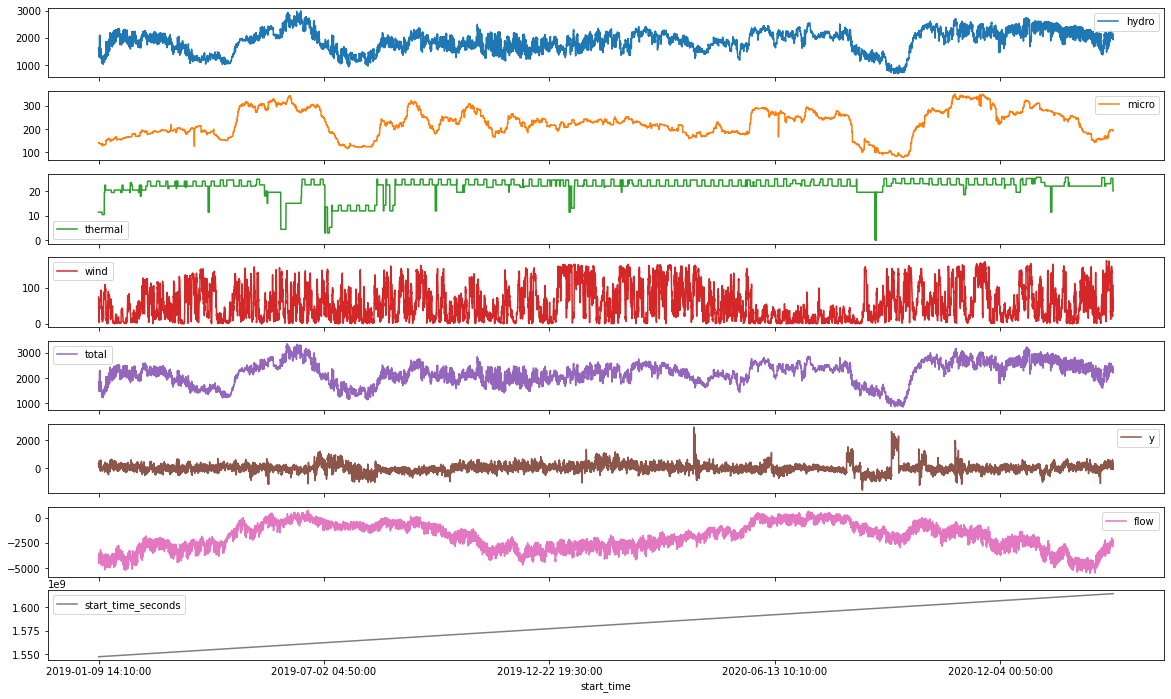

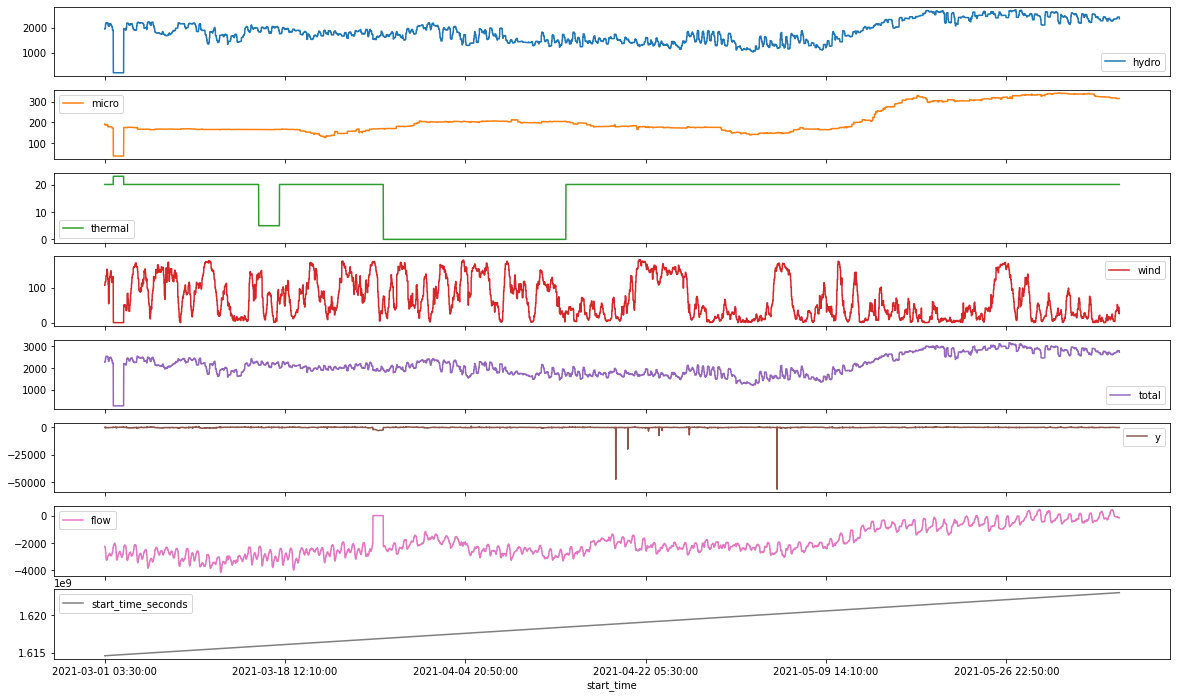

In [176]:
# Get column names from df_train except start_time
cols = df_train.columns.drop('start_time')
plot_features = df_train[cols]
plot_features.index = df_train['start_time']
_ = plot_features.plot(subplots=True, figsize=(20, 12))

# Do the same for df_val
plot_features = df_val.drop("start_time", axis=1)[cols]
plot_features.index = df_val['start_time']
_ = plot_features.plot(subplots=True, figsize=(20, 12))

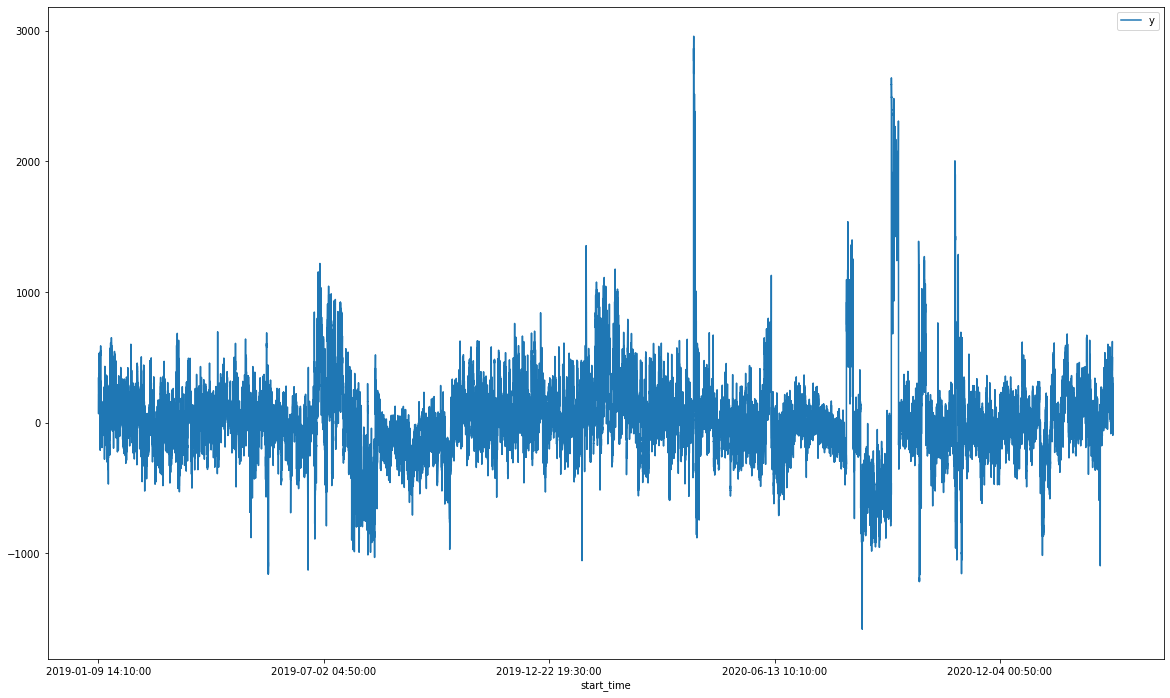

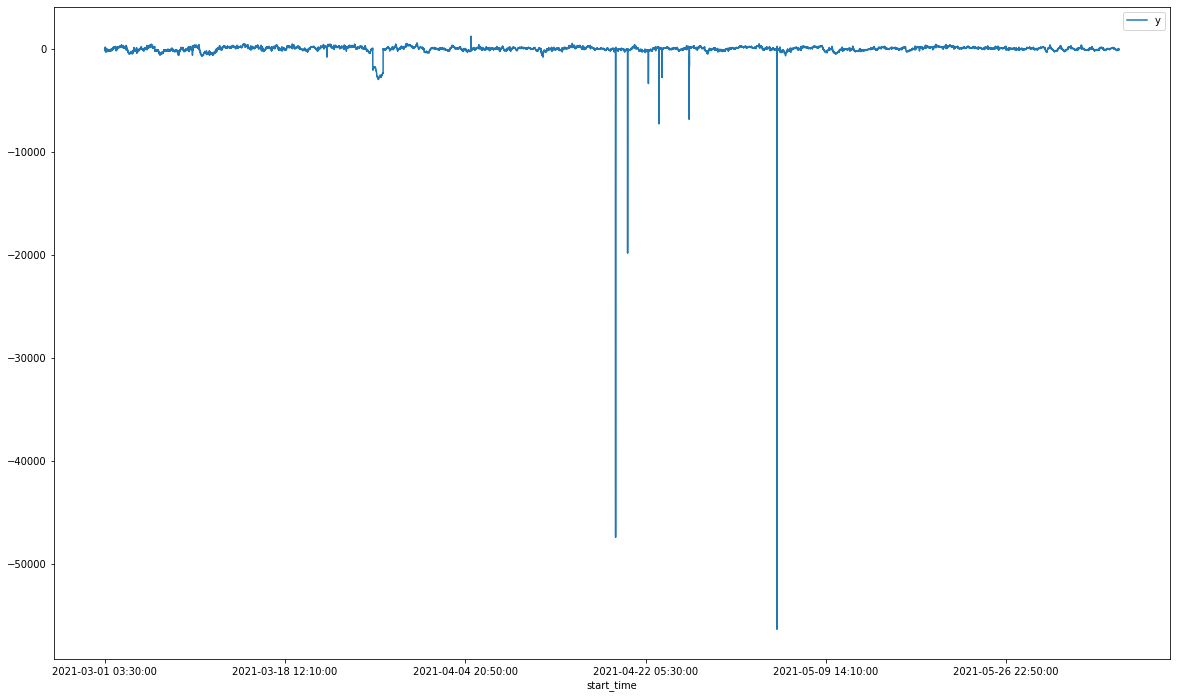

In [177]:
# Plot two different plots; one for df_train, one for df_val with feature "y"
plot_features = df_train[['y']]
plot_features.index = df_train['start_time']
_ = plot_features.plot(subplots=True, figsize=(20, 12))

# Do the same for df_val, but in a new plot 
plot_features = df_val[['y']]
plot_features.index = df_val['start_time']
_ = plot_features.plot(subplots=True, figsize=(20, 12))


There are some spikes in both datasets, especially the validation data, that seem rather inconsistent. Let's replace them with values based on the mean of the "y" value for other datapoints that have similar "total" feature.

In [178]:
def clamp_y(df: pd.DataFrame) -> pd.DataFrame:
    df1 = dfh.get_rows_between(df, 'total', 1500, 1550)
    df2 = dfh.get_rows_between(df1, 'y', -2900, 2900)
    mean_val = df2["y"].mean()
    q = (df["y"] > 1500) | (df["y"] < -1500)
    n_clamps = df.loc[q].shape[0]
    print(f"Percentage of rows clamped in training: {round(n_clamps / df.shape[0], 2) * 100}%")
    df.loc[q, "y"] = mean_val
    return df

df_train = clamp_y(df_train)
df_val = clamp_y(df_val)
if testing:
    df_test = clamp_y(df_test)

Percentage of rows clamped in training: 1.0%
Percentage of rows clamped in training: 1.0%


Let's see if there are any NaN-values present

In [179]:
# Check for NaN values
df_train.isnull().sum()

start_time            0
hydro                 0
micro                 0
thermal               0
wind                  0
total                 0
y                     0
flow                  0
start_time_seconds    0
dtype: int64

## Feature engineering
In this section, we will look at how we can manipulate the data in the dataset in order to better suit it for model prediction. This will include modifying existing features, and introducing new ones.

First we'll implement the required feature: previous_y

Second we'll look at frequencies.
The nature of demand on the power grid is highly dependent on two key factors:
* The time of day
* The time of year

Seeing as the price of electricity has been a heated debate for the past half-year due to environmental and seasonal changes, this might be a good place to start.

In [180]:
def add_day_periods(df: pd.DataFrame) -> pd.DataFrame:
    day = 24*60*60
    year = (365.2425)*day
    df['Day sin'] = np.sin(df['start_time_seconds'] * (2 * np.pi / day))
    df['Day cos'] = np.cos(df['start_time_seconds'] * (2 * np.pi / day))
    df['Year sin'] = np.sin(df['start_time_seconds'] * (2 * np.pi / year))
    df['Year cos'] = np.cos(df['start_time_seconds'] * (2 * np.pi / year))
    return df


df_train = add_day_periods(df_train)
df_val = add_day_periods(df_val)
if testing:
    df_test = add_day_periods(df_test)


Let's also add simple bucket-indicators for the time of day since this massively impacts the use of the power grid.
We will use the following buckets for the feature 'time_of_day':

* 0 = early morning. Times between 06:00 and 09:00
* 1 = late morning. Times between 09:00 and 12:00
* 2 = early day. Times between 12:00 and 15:00
* 3 = evening. Times between 15:00 and 18:00
* 4 = late evening. Times between 18:00 and 21:00
* 5 = early night. Times between 21:00 and 00:00
* 6 = night time. Times between 00:00 and 06:00

In [181]:
def add_time_of_day(df: pd.DataFrame) -> pd.DataFrame:
    df['hours'] = pd.to_datetime(df['start_time']).apply(lambda x: x.hour)
    df['time_of_day'] = 0
    # If time_of_day is between 6 and 8, set it to 0
    df.loc[(df['hours'] >= 6) & (df['hours'] <= 8), 'time_of_day'] = 0
    # If between 9 and 11, set it to 1
    df.loc[(df['hours'] >= 9) & (df['hours'] <= 11), 'time_of_day'] = 1
    # If between 12 and 14, set it to 2
    df.loc[(df['hours'] >= 12) & (df['hours'] <= 14), 'time_of_day'] = 2
    # If between 15 and 17, set it to 3
    df.loc[(df['hours'] >= 15) & (df['hours'] <= 17), 'time_of_day'] = 3
    # If between 18 and 20, set it to 4
    df.loc[(df['hours'] >= 18) & (df['hours'] <= 20), 'time_of_day'] = 4
    # If between 21 and 23, set it to 5
    df.loc[(df['hours'] >= 21) & (df['hours'] <= 23), 'time_of_day'] = 5
    # If between 0 and 5, set it to 6
    df.loc[(df['hours'] >= 0) & (df['hours'] <= 5), 'time_of_day'] = 6
    df.drop(columns='hours', inplace=True)
    return df

df_train = add_time_of_day(df_train)
df_val = add_time_of_day(df_val)
if testing:
    df_test = add_time_of_day(df_test)

Now we will apply the same logic for time_of_week, however we will have to use different buckets. We'll simply add one bucket for each day of the week, i.e. 0 for monday, 1 for tuesday, etc..
We will also add an arbitrary feature called 'weekend', which will apply to saturday and sunday (1 for 'weekend' = True, else 0)

In [182]:
def add_time_of_week(df: pd.DataFrame) -> pd.DataFrame:
    df['time_of_week'] = pd.to_datetime(df['start_time']).apply(lambda x: x.weekday())
    # If time_of_week = 5 or 6, set feature 'weekend' to 1. Else set to 0
    df['weekend'] = 0
    df.loc[(df['time_of_week'] == 5) | (df['time_of_week'] == 6), 'weekend'] = 1
    return df

df_train = add_time_of_week(df_train)
df_val = add_time_of_week(df_val)
if testing:
    df_test = add_time_of_week(df_test)

Finally, we get to time_of_year. Here we will simply use the different months that the dates correspond to. Using this, we will also add a feature called 'season' to explicitly state whether we are in the summer, winter, autumn, or spring.
We will bucket the season as follows using [this](https://snl.no/%C3%A5rstider) definition:

* Spring will go from March through May
* Summer will start in June, and end with (including) August
* Autumn then starts from September, and runs until November
* Finally, winter runs from December through February

In [183]:
def add_time_of_year(df: pd.DataFrame) -> pd.DataFrame:
    df['time_of_year'] = pd.to_datetime(df['start_time']).apply(lambda x: x.month)
    df['season'] = 0
    # If time_of_year is between 3 and 5, set it to 0
    df.loc[(df['time_of_year'] >= 3) & (df['time_of_year'] <= 5), 'season'] = 0
    # If between 6 and 8, set it to 1
    df.loc[(df['time_of_year'] >= 6) & (df['time_of_year'] <= 8), 'season'] = 1
    # If between 9 and 11, set it to 2
    df.loc[(df['time_of_year'] >= 9) & (df['time_of_year'] <= 11), 'season'] = 2
    # If between 12 and 2, set it to 3
    df.loc[df['time_of_year'] == 12, 'season'] = 3
    df.loc[df['time_of_year'] <= 2, 'season'] = 3
    return df

df_train = add_time_of_year(df_train)
df_val = add_time_of_year(df_val)
if testing:
    df_test = add_time_of_year(df_test)

We don't need the features that give us the time in raw values anymore, therefore we remove them.

In [184]:
df_train.drop(columns=['start_time', 'start_time_seconds'], inplace=True)
df_val.drop(columns=['start_time', 'start_time_seconds'], inplace=True)
if testing:
    df_test.drop(columns=['start_time', 'start_time_seconds'], inplace=True)

Finally, we add one-hot encoding of these variables to make the dataframe more sparse

In [185]:
# One-hot encode the columns with time_of_day, time_of_week, time_of_year, and season
one_hot_feats = ['time_of_day', 'time_of_week', 'time_of_year', 'season']
df_train = pd.get_dummies(df_train, columns=one_hot_feats)
df_val = pd.get_dummies(df_val, columns=one_hot_feats)
if testing:
    df_test = pd.get_dummies(df_test, columns=one_hot_feats)

In [186]:
# The following features did not get added to df_test since they are not observed, therefore they must be added manually
diff_feats = [a for a in df_train.columns if a not in df_val.columns]
df_val[diff_feats] = 0
if testing:
    df_test[diff_feats] = 0

Let's now just add a bunch of lagged variables. This is mainly because the model seems to heavily weight the data from the very near past, so let's just try to reinforce this

In [187]:
hours = [24, 12, 6]
feats = ['total', 'flow']

for hour in hours:
    for feat in feats:
        df_train = dfh.add_shift(df_train, feat, hour)
        df_val = dfh.add_shift(df_val, feat, hour)
        if testing:
            df_test = dfh.add_shift(df_test, feat, hour)

We will now add the feature 'previous_y', which is the imbalance from the previous timestep. We will then use this value to add a rolling average for the last 24, 12, 6, and 3 hours, meaning we get 4 additional features that measure the average 'previous_y' value based on those previous hour segments.

Note that unlike ```add_shift```, ```add_shifted_target``` shifts by 1 hard-coded index, rather than a variable number of hours (this is why they are 2 different functions).

In [188]:
df_train = dfh.add_shifted_target(df_train, 'y')
df_val = dfh.add_shifted_target(df_val, 'y')
if testing:
    df_test = dfh.add_shifted_target(df_test, 'y')

hours = [3, 6, 12, 24]
for h in hours:
    df_train = dfh.add_rolling_avg(df_train, 'y', h)
    df_val = dfh.add_rolling_avg(df_val, 'y', h)
    if testing:
        df_test = dfh.add_rolling_avg(df_test, 'y', h)

Let's finally get a glimpse of what the dataframe looks like now that feature engineering is completed.

In [189]:
df_train.head()

,hydro,micro,thermal,wind,total,y,flow,Day sin,Day cos,Year sin,...,flow_shift_24,total_shift_12,flow_shift_12,total_shift_6,flow_shift_6,previous_y,y_avg_prev_3h,y_avg_prev_6h,y_avg_prev_12h,y_avg_prev_24h
0,1591.839,141.928,11.5,74.428,1819.695,341.330021,-4417.4,-0.537300,-0.843391,0.149238,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,1591.839,141.928,11.5,74.428,1819.695,330.114330,-4417.4,-0.555570,-0.831470,0.149297,...,0.0,0.0,0.0,0.0,0.0,341.330021,0.0,0.0,0.0,0.0
2,1591.839,141.928,11.5,74.428,1819.695,323.877221,-4417.4,-0.573576,-0.819152,0.149356,...,0.0,0.0,0.0,0.0,0.0,330.114330,0.0,0.0,0.0,0.0
3,1591.839,141.928,11.5,74.428,1819.695,296.438463,-4417.4,-0.591310,-0.806445,0.149416,...,0.0,0.0,0.0,0.0,0.0,323.877221,0.0,0.0,0.0,0.0
4,1591.839,141.928,11.5,74.428,1819.695,269.097132,-4417.4,-0.608761,-0.793353,0.149475,...,0.0,0.0,0.0,0.0,0.0,296.438463,0.0,0.0,0.0,0.0


## Modelling and predictions
In this section, we will create an agent containing a RNN model which will train on the dataset, as well as predict on validation/testing data.

In [194]:
# Whether to use 5 or 15 minute resolution
RESOLUTION = 5
# Number of previous timesteps to train/predict on
N_PREV = 24
# Standard batch size
BATCH_SIZE = 64
# Number of epochs to train for
EPOCHS = 300
# Learning rate of LSTM model
LR = 0.0001
# Number of units and layers in LSTM model
LSTM_UNITS = [24]
# Number of Dense units and layers
DENSE_UNITS = [16]
# Target column (either 'y' or 'altered_imbalance')
TARGET = 'y'

model = ml.get_model(LSTM_UNITS, DENSE_UNITS, LR)

agent = ag.Agent(
    min_scale=-1,
    max_scale=1,
    resolution=RESOLUTION,
    n_prev=N_PREV,
    batch_size=BATCH_SIZE,
    target=TARGET,
    verbose=True,
    model=model,
    filepath=f'./models/{TARGET}_model_lr={LR}_epochs={EPOCHS}_b_size={BATCH_SIZE}_lstm={LSTM_UNITS}_dense={DENSE_UNITS}.h5',
)

AttributeError: module 'model' has no attribute 'get_model'

In [191]:
if agent.target == 'altered_imbalance':
    df_train = dfh.add_altered_forecast(df_train, ['total', 'flow'], market_time='hourly')
    df_train = df_train.drop(columns='y')
    df_val = dfh.add_altered_forecast(df_val, ['total', 'flow'], market_time='hourly')
    df_val = df_val.drop(columns='y')
    if testing:
        df_test = dfh.add_altered_forecast(df_test, ['total', 'flow'], market_time='hourly')
        df_test = df_test.drop(columns='y')

agent.fit_scalers(df_train)
df_train = agent.transform(df_train)
df_val = agent.transform(df_val)
if testing:
    df_test = agent.transform(df_test)

In [192]:
history = agent.train(train=df_train, valid=df_val, epochs=EPOCHS, force_relearn=True)

Forcing relearn...
Could not load model from ./models/y_model_5_24_64_300.h5. Training new model.
Generating training data...

===== CALLING MAKE_DATASET =====
Processing chunk 0
Processing chunk 40000
Processing chunk 30000
Processing chunk 20000
Processing chunk 10000
Processing chunk 50000
Processing chunk 80000
Processing chunk 60000
Processing chunk 70000
Processing chunk 100000
Processing chunk 120000
Processing chunk 130000
Processing chunk 90000
Processing chunk 110000
Processing chunk 140000Processing chunk 150000

Processing chunk 160000
Processing chunk 170000
Processing chunk 210000
Processing chunk 190000
Processing chunk 220000
Processing chunk 200000
Processing chunk 180000
Finished making dataset.

Generating validation data...

===== CALLING MAKE_DATASET =====
Processing chunk 0
Processing chunk 10000
Processing chunk 20000
Finished making dataset.

Epoch 1/300
7030/7034 [============================>.] - ETA: 0s - loss: 0.0101 - mean_absolute_error: 0.0606
Epoch 1: sa

KeyboardInterrupt: 

In [ ]:
loss_per_epoch = history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
x_valid = df_val.drop(agent.target, axis=1)
x_valid.head()

In [ ]:
N_TIMESTEPS = 24
y_true = agent.scalers['y'].inverse_transform(df_val['y'].to_numpy().reshape(-1,1))
agent.visualize_multiple_predictions(x_valid, y_true, n_timesteps=N_TIMESTEPS, replace=False, n_batches=10)

In [ ]:
df_val = dfh.add_altered_forecast(df_val, ['total', 'flow'])

In [ ]:
df_val['y'].equals(df_val['altered_forecast'])